# XRF physics - the gory details  

> How to compute your own spectrum from fundamental constants   

**If you are not into physics, you can safely skip this section.**

In a previous section of this documentation I described how one can use the `ElementXRF(<element>)` class to compute an x-ray fluorescence spectrum object for a given chemical element. The whole point of the `moseley`  package is to enable you to do so but to protect you from the gory details of XRF physics. However, in case you are interested to learn how this computation is done you can find the details of that calculation here.     

The modeling of X-ray fluorescence spectra is described in a nice tutorial *Basic Fundamental Parameters in X-Ray Fluorescence* by Volker Thomsen [online](https://www.spectroscopyonline.com/view/basic-fundamental-parameters-x-ray-fluorescence) and as [pdf](https://github.com/fligt/moseley/blob/master/pdf/Thomsen_2007_Basic-fundamental-parameters-in-X-ray-fluorescence.pdf).

    @Article{Thomsen_2007,
      author    = {Thomsen, Volker},
      title     = {Basic fundamental parameters in X-ray fluorescence},
      journal   = {SPECTROSCOPY-SPRINGFIELD THEN EUGENE THEN DULUTH-},
      year      = {2007},
      volume    = {22},
      number    = {5},
      pages     = {46-50},
      url       = {https://www.spectroscopyonline.com/view/basic-fundamental-parameters-x-ray-fluorescence},
    }

The fundamental parameters are measured x-ray properties of chemical elements that we need to look up somehow. Not so very long ago physicist would look up the x-ray fluorescence energies and other measured properties of different chemical elements in the *X-RAY DATA BOOKLET*. Instead, more conveniently I will show how to look up those values programmatically using the well documented python package. See [pypi](https://pypi.org/project/xraydb/) and [github](https://github.com/xraypy/XrayDB). One can also consult these values in the XRayDB [interactive web app](https://xraydb.xrayabsorption.org/element/Fe). 


<a href="https://cxro.lbl.gov/x-ray-data-booklet"><img width=20% src="https://cxro.lbl.gov//images/X-Ray-Data-Booklet/x-ray-data-booklet-324px-v02.jpg"></a>

So, let's see how we can implement some of the equations in the tutorial by Volker Thomsen and look up the required parameter values using `xraydb`...


## Pure iron 

Let's check if we can reproduce the numerical example for the intensity of the iron $K_{\alpha}$ emission intensity of a thick pure iron irradiated by a cadmium isotope emitting at 22.1 keV. Here is the approximate equation describing the intensity of the $K_{\alpha}$ peak for a thick sample of iron. *The emission intensity quickly approaches a maximum due to the limited penetration of the radiation into the sample*: 

$$ I_i = (I_0 C_i J_K g_{Ka} \omega_K)(\Omega/4 \pi)\frac{\mu_i}{\mu_s + \mu_{s,Ei}} \tag{Thomsen eq. 12}$$


Let's try to extract numerical values for the transition probability $g_{K \alpha}$, the jump ratio coefficient $J_K$, the fluorescence yield $\omega_K$ and the mass absorption coefficients at the at the incoming energy $\mu_{i}$ and emission energy $\mu_{s,Ei}$ from `xraydb`. 

$$g_{K \alpha} = 0.882$$ 

$$J_K = 0.877$$ 

$$\omega_K = 0.347$$ 

$$\mu_i = \mu_s = 18.55 cm^2/g \tag{at 22.1 keV}$$ 

$$\mu_{s,Ei} = 70.46 cm^2/g \tag{at 6.4 keV} $$ 


### Transition probability $g_{K_{\alpha}}$


Let's take a look at to transition probability $ g_{K \alpha}$. This the probability that $K_{\alpha}$ radiation will be emitted rather than that of another K line which is given by:  

$$ g_{K\alpha} = \frac{I(K_{\alpha})}{I(K_{\alpha}) + I(K_{\beta}) +...} \tag{Thomsen eq. 6} $$

Starting point for all calculations is an overview of emission lines for the element of interest these can be accessed using the function `xray_lines()`. 

In [ ]:
import xraydb  

In [ ]:
xraydb.xray_lines('Fe')

{'Ka3': XrayLine(energy=6267.4, intensity=0.000276096, initial_level='K', final_level='L1'),
 'Ka2': XrayLine(energy=6392.1, intensity=0.294023, initial_level='K', final_level='L2'),
 'Ka1': XrayLine(energy=6405.2, intensity=0.580277, initial_level='K', final_level='L3'),
 'Kb3': XrayLine(energy=7059.3, intensity=0.0425566, initial_level='K', final_level='M2'),
 'Kb1': XrayLine(energy=7059.3, intensity=0.0821556, initial_level='K', final_level='M3'),
 'Kb5': XrayLine(energy=7110.0, intensity=0.000712115, initial_level='K', final_level='M4,5'),
 'Lb4': XrayLine(energy=791.9, intensity=0.413833, initial_level='L1', final_level='M2'),
 'Lb3': XrayLine(energy=791.9, intensity=0.586166, initial_level='L1', final_level='M3'),
 'Ln': XrayLine(energy=628.6, intensity=0.0742626, initial_level='L2', final_level='M1'),
 'Lb1': XrayLine(energy=717.9, intensity=0.925737, initial_level='L2', final_level='M4'),
 'Ll': XrayLine(energy=615.5, intensity=0.0990365, initial_level='L3', final_level='M1'),


The names of these lines are denoted in [Siegbahn](https://en.wikipedia.org/wiki/Siegbahn_notation) notation (e.g. *Ka3*, where '*a*' stands for alpha). The lines are grouped according to their initial level, denoted with the IUPAC notation e.g. 'K' or 'L1'. Within these groups the `intensities` a.k.a. transition probabilities are normalized to unity. The intensity of the $K_{\alpha}$ line is actually a sum of multiple overlapping `Ka` lines. 

To the `xray_lines()` function one could provide an additional argument of an `excitation_energy` (in units of electron Volts [eV]) . This simply crops the list to emission lines below the corresponding edge, like so:

In [ ]:
xraydb.xray_lines('Fe', excitation_energy=7111) # just below the K edge at 7112

{'Lb4': XrayLine(energy=791.9, intensity=0.413833, initial_level='L1', final_level='M2'),
 'Lb3': XrayLine(energy=791.9, intensity=0.586166, initial_level='L1', final_level='M3'),
 'Ln': XrayLine(energy=628.6, intensity=0.0742626, initial_level='L2', final_level='M1'),
 'Lb1': XrayLine(energy=717.9, intensity=0.925737, initial_level='L2', final_level='M4'),
 'Ll': XrayLine(energy=615.5, intensity=0.0990365, initial_level='L3', final_level='M1'),
 'La2': XrayLine(energy=704.8, intensity=0.0892847, initial_level='L3', final_level='M4'),
 'La1': XrayLine(energy=704.8, intensity=0.811679, initial_level='L3', final_level='M5')}

Let's see if the iron $K$ intensities sum up to unity. 

In [ ]:
Fe_lines = xraydb.xray_lines('Fe') 
Fe_names = list(Fe_lines.keys())
FeK_names = [name for name in Fe_names if name.startswith('K')]
FeKa_names = [name for name in Fe_names if name.startswith('Ka')]
FeKb_names = [name for name in Fe_names if name.startswith('Kb')]

FeK_total = sum([Fe_lines[l].intensity for l in FeK_names])
FeKa_intensity = sum([Fe_lines[l].intensity for l in FeKa_names])
FeKb_intensity = sum([Fe_lines[l].intensity for l in FeKb_names])

print(Fe_names)
print(FeKa_names)
print(FeKb_names) 

print(f'Fe_Ka intensity: {FeKa_intensity:.04f}, Fe_Kb intensity: {FeKb_intensity:.04f}')     
print(f'Fe_K total: {FeK_total:.04f}')

['Ka3', 'Ka2', 'Ka1', 'Kb3', 'Kb1', 'Kb5', 'Lb4', 'Lb3', 'Ln', 'Lb1', 'Ll', 'La2', 'La1']
['Ka3', 'Ka2', 'Ka1']
['Kb3', 'Kb1', 'Kb5']
Fe_Ka intensity: 0.8746, Fe_Kb intensity: 0.1254
Fe_K total: 1.0000


The transition probability value reported by Thomsen $g_{K\alpha} = 0.882$ is actually **one percent higher** then our calculated value $0.8746$. Perhaps this is due to to the varying energies within a line envelope. 

### Jump ratio coefficient $J_K$

For each line the initial level corresponds to a specific absorption edge (denoted with IUPAC notation e.g. 'K' or 'L1'. An overview can be found using `xray_edges()`.  

In [ ]:
xraydb.xray_edges('Fe')

{'K': XrayEdge(energy=7112.0, fyield=0.350985, jump_ratio=7.893),
 'L1': XrayEdge(energy=844.6, fyield=0.001, jump_ratio=1.1289),
 'L2': XrayEdge(energy=719.9, fyield=0.0036, jump_ratio=1.4),
 'L3': XrayEdge(energy=706.8, fyield=0.0063, jump_ratio=3.099),
 'M1': XrayEdge(energy=91.3, fyield=2.8e-06, jump_ratio=1.0),
 'M2': XrayEdge(energy=52.7, fyield=1.6e-05, jump_ratio=1.0),
 'M3': XrayEdge(energy=52.7, fyield=0.0, jump_ratio=1.0),
 'M4': XrayEdge(energy=2.0, fyield=0.00219375, jump_ratio=1.0),
 'M5': XrayEdge(energy=2.0, fyield=0.0, jump_ratio=1.0)}

More convenient, the properties of a specific element edge can be found using the function `xray_edge()`.  

In [ ]:
xraydb.xray_edge('Fe', 'K')

XrayEdge(energy=7112.0, fyield=0.350985, jump_ratio=7.893)

From the jump ratio $r_K$ the jump ratio coefficient can be calculated using 

$$ J_K = \frac{r_K -1}{r_K} \tag{Thomsen eq. 4}$$

In [ ]:
r_K = xraydb.xray_edge('Fe', 'K').jump_ratio
J_K = (r_K - 1) / r_K
print(f'Jump ratio coefficient: {J_K:.03f}')

Jump ratio coefficient: 0.873


Ok, our computed value corresponds quite well with the value 0.877 reported by Thomsen.  

### Fluorescence yield $\mathbf{\omega_K}$



Thomsen writes: *The last factor, the probability of $K$ radiation rather than the production of an Auger electron, is called the fluorescence yield* $\omega_K$. The dependence of the fluorescence yield for a specific edges $K$ and $L$ as a function of the atomic number is depicted in figure 4. Let's reproduce these curves with `xraydb`. 

As a first step, we need a list of chemical elements for increasing atomic number **Z**. 

In [ ]:
Z_list = list(range(1, 92))
element_list = [xraydb.atomic_symbol(Z) for Z in Z_list]
print(element_list)

['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th', 'Pa']


In [ ]:
Z_list_L = list(range(15, 92)) # Lighter elements do no have an L shell 
element_list_L = [xraydb.atomic_symbol(Z) for Z in Z_list_L] 

In [ ]:
fyield_K_list = [xraydb.xray_edge(e, 'K').fyield for e in element_list]
fyield_L_list = [xraydb.xray_edge(e, 'L2').fyield for e in element_list_L]

# for iron K the fluorescence yield is 
Z_Fe = 26 
fyield_FeK = xraydb.xray_edge('Fe', 'K').fyield

In [ ]:
import matplotlib.pyplot as plt 

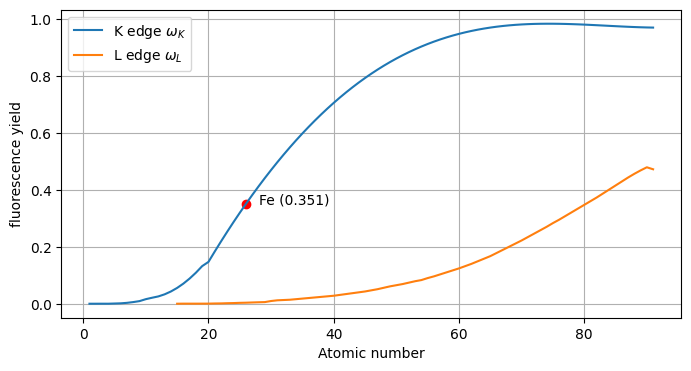

In [ ]:
fig, ax = plt.subplots(figsize=[8, 4]) 

ax.plot(Z_list, fyield_K_list, label=r'K edge $\omega_K$')
ax.plot(Z_list_L, fyield_L_list, label=r'L edge $\omega_L$')
ax.scatter(Z_Fe, fyield_FeK, color='r')
ax.annotate(f'Fe ({fyield_FeK:.03f})', [Z_Fe+2, fyield_FeK])
ax.set_xlabel('Atomic number')
ax.set_ylabel('fluorescence yield')
ax.grid()
ax.legend();

Ok, so we see that the computed fluorescence yield value 0.351 for the iron K edge $\mathbf{\omega_K}$ corresponds to the reported value by thomsen 0.347 pretty well. 

### Combining it all 

We now have all ingredients to compute a theoretical (excitation) x-ray fluorescence spectrum with the function `xrf_spectrum_xy()`. This function for each peak multiplies transition probability, jump ratio coefficient and fluorescence yield to obtain a theoretical excitation spectrum. Note that we do not yet take into account absorption effects or scattering effects. For comparison we plot this with the spectrum generated with my `moseley` package. 

In [ ]:
from moseley import ElementXRF 
import matplotlib.pyplot as plt

In [ ]:
Fe_xrf = ElementXRF('Fe', excitation_energy_keV=22)

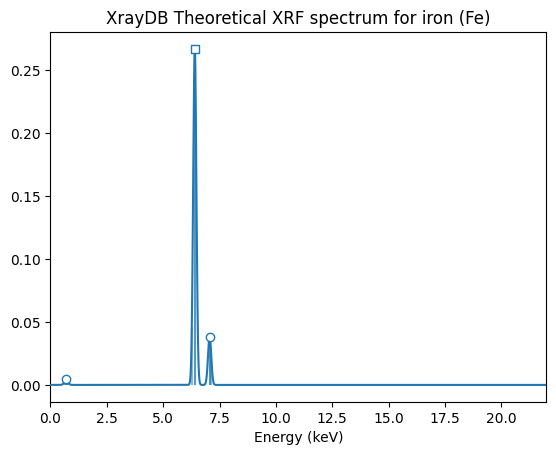

In [ ]:
fig, ax = plt.subplots()

Fe_xrf.plot_spectrum(ax=ax)
ax.set_title(f'XrayDB Theoretical XRF spectrum for iron (Fe)')
ax.set_xlim([0, 22]);


# More ideas 

## Absorption and scattering 

The xraydb documentation gives an example calculation for different mass attenuation cross sections.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from xraydb import mu_elam 
import xraydb

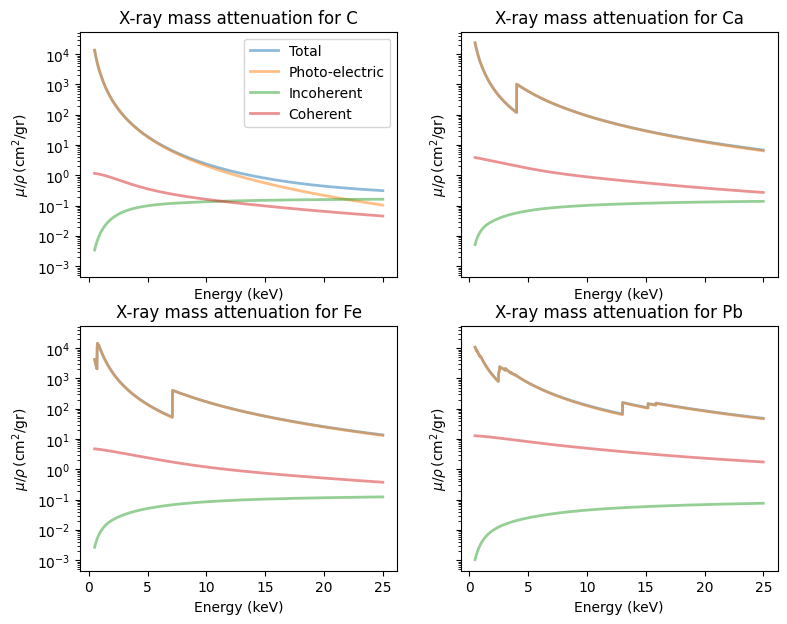

In [ ]:
energy = np.arange(500, 25000, 10)  # energy in eV
energy_keV = energy / 1000 


fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[9, 7], sharex=True, sharey=True) 
axs = axs.flatten()

elements = ['C', 'Ca', 'Fe', 'Pb']

for i, elem in enumerate(elements):       

    mu_total = mu_elam(elem, energy, kind='total')
    mu_photo = mu_elam(elem, energy, kind='photo')
    mu_incoh = mu_elam(elem, energy, kind='incoh')
    mu_coher = mu_elam(elem, energy, kind='coh')


    ax = axs[i]

    ax.set_title(f'X-ray mass attenuation for {elem}')
    ax.plot(energy_keV, mu_total, linewidth=2, label='Total', alpha=0.5)
    ax.plot(energy_keV, mu_photo, linewidth=2, label='Photo-electric', alpha=0.5)
    ax.plot(energy_keV, mu_incoh, linewidth=2, label='Incoherent', alpha=0.5)
    ax.plot(energy_keV, mu_coher, linewidth=2, label='Coherent', alpha=0.5)

    ax.set_xlabel('Energy (keV)')
    ax.set_ylabel(r'$\mu/\rho \rm\, (cm^2/gr)$')
    #ax.legend()
    ax.set_yscale('log')
    
axs[0].legend();

I would like to see how scattering depends on atomic number $Z$.

In [ ]:
Z0 = xraydb.atomic_number('H')
Z1 = xraydb.atomic_number('Pb') + 1
element_list = [xraydb.atomic_symbol(Z) for Z in range(Z0, Z1)]
print(element_list)

['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb']


In [ ]:
energy = np.arange(500, 25000, 10)  # energy in eV
energy_keV = energy / 1000  

elements = element_list

print(elements)

['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb']


In [ ]:
mu_incoh_list = []
mu_coh_list = []
mu_photo_list = []

for elem in elements: 
    
    mu_incoh = xraydb.mu_elam(elem, energy, kind='incoh')
    mu_incoh_list.append(mu_incoh)
    
    mu_coh = xraydb.mu_elam(elem, energy, kind='coh')
    mu_coh_list.append(mu_coh)
    
    mu_photo = xraydb.mu_elam(elem, energy, kind='photo')
    mu_photo_list.append(mu_photo)


K = np.array(mu_photo_list)
S = np.array(mu_coh_list) + np.array(mu_incoh_list) # ignore Compton shift 

In [ ]:
cmap = plt.get_cmap('viridis_r')
gradient = np.linspace(0, 1, len(elements))
colors = cmap(gradient)

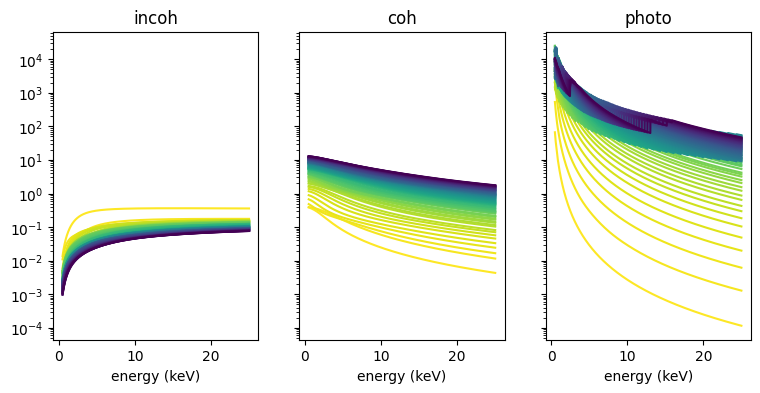

In [ ]:
fig, [ax0, ax1, ax2] = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=[9, 4])

for i, mu in enumerate(mu_incoh_list): 
    ax0.plot(energy_keV, mu, label=elements[i], color=colors[i]) 
    ax0.set_xlabel('energy (keV)')
    
for i, mu in enumerate(mu_coh_list): 
    ax1.plot(energy_keV, mu, label=elements[i], color=colors[i])
    ax1.set_xlabel('energy (keV)')
    
for i, mu in enumerate(mu_photo_list): 
    ax2.plot(energy_keV, mu, label=elements[i], color=colors[i])
    ax2.set_xlabel('energy (keV)')

ax0.set_title('incoh')    
ax1.set_title('coh')    
ax2.set_title('photo')  

logscale = True 
if logscale == True:
    ax0.set_yscale('log')
    ax1.set_yscale('log')
    ax2.set_yscale('log')
#ax.legend()

The question now is if we can explain the lead shadow regions in some of light element peak maps. This problem is essentially combining the effects of scattering and absorption of a translucent layer. To calculate reflectance and transmission properties of such a system we can use the results of Kubelka-Munk theory. 

Given the relatively small energy shift due to inelastic (incoherent) scattering, we can simplify the problem by summing elastic (coherent) and inelastic (incoherent) scattering into a single scattering coefficient $S$. 

In [ ]:
def R_inf(K, S): 
    '''Infinite reflectance from `K` and `S`.
    
    Calculation with modified Saunderson equation. '''
     
    Rinf =  (S/K) / ((S/K) + 1 + np.sqrt(1 + 2 * (S/K))) 
    
    return Rinf 

In [ ]:
Rinf = R_inf(K, S)

In [ ]:
Rinf.shape

(82, 2450)

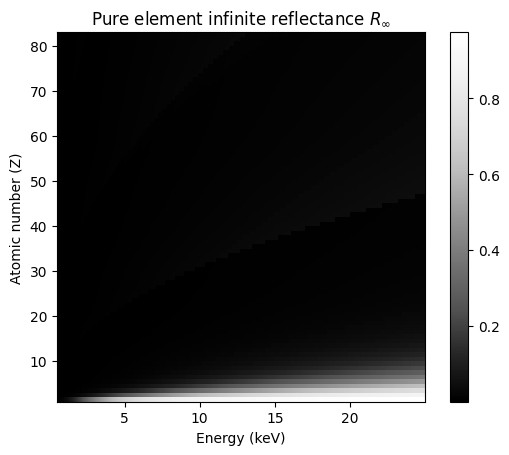

In [ ]:
fig, ax = plt.subplots()

extent = [energy_keV.min(), energy_keV.max(), Z0, Z1]

im = ax.imshow(Rinf, interpolation='none', origin='lower', aspect=0.3, extent=extent, cmap='Greys_r')

fig.colorbar(im, ax=ax)

ax.set_title(r'Pure element infinite reflectance $R_{\infty}$')
ax.set_xlabel('Energy (keV)')
ax.set_ylabel('Atomic number (Z)'); 
#ax.set_ylim([0, 20])

What we learn here is that the Compton ridge is essentially only due to the abundance of hydrogen in the paper. The scattering of carbon and oxygen can safely be neglected. 

Next step is the calculation of the transmission of a typical ( $200 ~ g/m^2$) paper... 

In [ ]:
mu_paper = xraydb.material_mu('C6H12O6', energy, 0.5)
mu_lead = xraydb.material_mu('PbCO3', energy, 20)
mu_iron = xraydb.material_mu('Fe', energy, 10)

In [ ]:
d_paper = 0.5 # mm 
d_lead = 0.001 # mm 
d_iron = 0.001 # mm 

T_paper = np.exp(-d_paper * mu_paper)
T_lead = np.exp(-d_lead * mu_lead)
T_iron = np.exp(-d_iron * mu_iron)

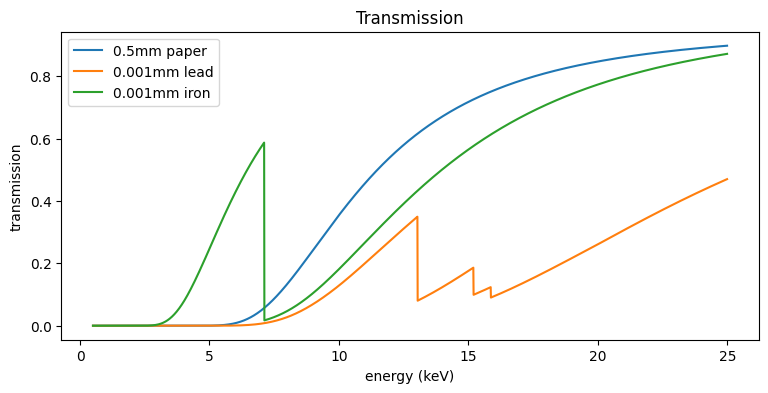

In [ ]:
fig, ax = plt.subplots(figsize=[9, 4])

ax.plot(energy_keV, T_paper, label=f'{d_paper}mm paper')
ax.plot(energy_keV, T_lead, label=f'{d_lead}mm lead')
ax.plot(energy_keV, T_iron, label=f'{d_iron}mm iron')
ax.set_title('Transmission')
ax.set_xlabel('energy (keV)')
ax.set_ylabel('transmission')
ax.legend();

So, the one million dollar question now is: what is the expected reflectance of the sandwich? 